In [1]:
import cv2
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def getSkeleton(image):
    t = time.time()
    MODE = "COCO"

    if MODE is "COCO":
        protoFile = "pose/coco/pose_deploy_linevec.prototxt"
        weightsFile = "pose/coco/pose_iter_440000.caffemodel"
        nPoints = 18
        POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

    elif MODE is "MPI" :
        protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
        weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
        nPoints = 15
        POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

    frame = image
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


    # input image dimensions for the network
    inWidth = 256
    inHeight = 256
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()


    H = output.shape[2]
    W = output.shape[3]

    # Empty list to store the detected keypoints
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold :
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)
    imgg = np.zeros((frameHeight, frameWidth ,3), np.uint8)
    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(imgg, points[partA], points[partB], (255, 255, 255), 9)
            #cv2.circle(imgg, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    gray = imgg.copy()
    gray = cv2.cvtColor(imgg, cv2.COLOR_RGB2GRAY)
    ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    image, contours,hierarchy = cv2.findContours(thresh1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = imgg[y:y+h,x:x+w]
#     print("Total time taken by network : {:.3f}".format(time.time() - t))    
    cv2.imwrite('picturefromcamera.jpg',crop)
    return crop




In [3]:
image = pose1 = cv2.imread('1.jpg')

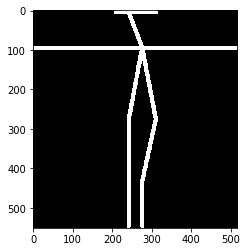

In [4]:
plt.imshow(getSkeleton(image))

In [5]:
from keras.models import load_model
new_model = load_model('poses1epoch.h5')
from keras.preprocessing import image


Using TensorFlow backend.


In [6]:
def predictPose(sleep_time=0):
    """sleep_time waits to start camera for a specified number of seconds"""
    
    cap = cv2.VideoCapture(0)
    time.sleep(sleep_time)
    
    t = time.time()
    ret, frame = cap.read()
    
    plt.imshow(frame)
    plt.show()
    
    ret, frame = cap.read()

    
    frame = getSkeleton(frame)
    
    cap.release()


    pose_file = 'picturefromcamera.jpg'
    pose = image.load_img(pose_file, target_size=(150, 150))

    pose = image.img_to_array(pose)

    pose = np.expand_dims(pose, axis=0) #so the network can think its a batch of one image
    pose = pose/255

    prediction_prob = new_model.predict(pose)
#     new_model.predict_classes(pose)
#     prediction_prob = new_model.predict(pose)
    
    i = 0
    for i in range(len(prediction_prob[0])):
        print("{0:.2f}".format(prediction_prob[0][i]))
    
    print("Total time taken by network : {:.3f}".format(time.time() - t),"seconds")    

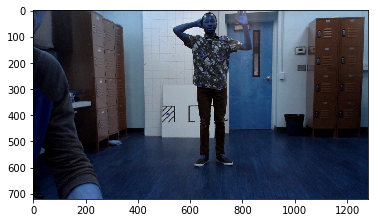

0.00
0.00
0.00
0.00
Total time taken by network : 3.581 seconds


In [17]:
predictPose(1)
